<a href="https://colab.research.google.com/github/wlgml014/bdas_proj-4/blob/main/Isolationforest%EB%AF%BC%EA%B7%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
col = [4, 5, 6,7,10,11,12,15]
Fuzzy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/Fuzzy_dataset_pre.csv', usecols = col)
#,usecols = col

In [ ]:
print(Fuzzy)
Fuzzy.info()
Fuzzy.head()
Fuzzy['Label'].value_counts()

         Data[0]  Data[1]  Data[2]  Data[3]  Data[6]  Data[7]  Label  \
0            216        0        0      138        0        0      0   
1            255      127        0        5        0        0      0   
2              0        0        0        0        7       21      0   
3              0       33       16      255        0        0      0   
4             25      128        0      255        7       96      0   
...          ...      ...      ...      ...      ...      ...    ...   
3838855      254       89        0        0        0        0      0   
3838856       24       33       33       48      109       25      0   
3838857       36        0      154       29      189        0      0   
3838858      220      183      127       20        0       20      0   
3838859      216        0        0      139        0        0      0   

         interval_id  
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000

0    3347013
2     491847
Name: Label, dtype: int64

In [ ]:
# target 별 분리
Fuzzy_0 = Fuzzy[Fuzzy['Label'] == 0]
Fuzzy_2 = Fuzzy[Fuzzy['Label'] == 2]

X = Fuzzy_0.drop(['Label'], axis=1)
Y = Fuzzy_0['Label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_outlier = Fuzzy_2.drop(['Label'], axis=1)
Y_outlier = Fuzzy_2['Label']
#정상데이터만 빼내고 8:2로 8 학습, 2랑 fuzzy데이터 합쳐서 accuracy 측정
#학습용 정상데이터 260만
#정상 68만 비정상 50만


In [ ]:
X_rtest = pd.concat([X_test, X_outlier])

In [ ]:
Y_rtest = pd.concat([Y_test, Y_outlier])

In [ ]:
Y_rtest

3054954    0
326308     0
3063678    0
704410     0
1729661    0
          ..
2930194    2
2930197    2
2930198    2
2930200    2
2930202    2
Name: Label, Length: 1161250, dtype: int64

In [ ]:
X_rtest

,Data[0],Data[1],Data[2],Data[3],Data[6],Data[7],interval_id
3054954,8,0,0,0,0,0,0.019824
326308,0,0,0,0,0,0,0.049950
3063678,0,0,0,0,3,119,0.009020
704410,216,86,0,138,0,0,0.010061
1729661,24,128,0,255,9,97,0.008935
...,...,...,...,...,...,...,...
2930194,86,56,18,97,107,132,1.778814
2930197,102,213,193,204,152,220,9.313973
2930198,181,172,171,157,155,228,8.706384
2930200,75,37,121,195,169,106,1.662301


In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_rtest = scaler.transform(X_rtest)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded_output = self.autoencoder.layers[-1](decoder_input)  # 마지막 레이어는 디코더 레이어입니다.
        decoder = Model(inputs=decoder_input, outputs=decoded_output)
        decoded_X = decoder.predict(encoded_X)
        return decoded_X

In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
X_train.shape[1]

7

In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_par ams['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_rtest)

36290/36290 [==============================] - 54s 1ms/step


# **IF_REAL**

In [ ]:
from sklearn.ensemble import IsolationForest
outlier_fraction = 0.14

print(outlier_fraction)


0.14


In [ ]:

# Isolation Forest 모델 생성 및 학습
clf = IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (3347013) is greater than the total number of samples (2677610). max_samples will be set to n_samples for estimation.
  warn(


In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2

Accuracy Score :
0.913659418729817
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    669403
           2       0.84      0.99      0.91    491847

    accuracy                           0.91   1161250
   macro avg       0.91      0.92      0.91   1161250
weighted avg       0.93      0.91      0.91   1161250



<Axes: >

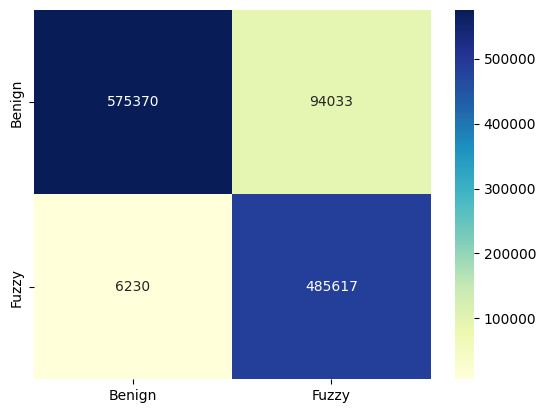

In [ ]:

#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_rtest,y_pred))
print("Classification Report :")
print(classification_report(Y_rtest,y_pred))

cm = confusion_matrix(Y_rtest, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **IF_REAL_0.1**

In [ ]:
# Isolation Forest 모델 생성 및 학습
clf = IsolationForest(n_estimators=100, max_samples=len(encoded_X_train), contamination=0.1,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2

Accuracy Score :
0.935907857911733
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    669403
           2       0.88      0.99      0.93    491847

    accuracy                           0.94   1161250
   macro avg       0.93      0.94      0.94   1161250
weighted avg       0.94      0.94      0.94   1161250



<Axes: >

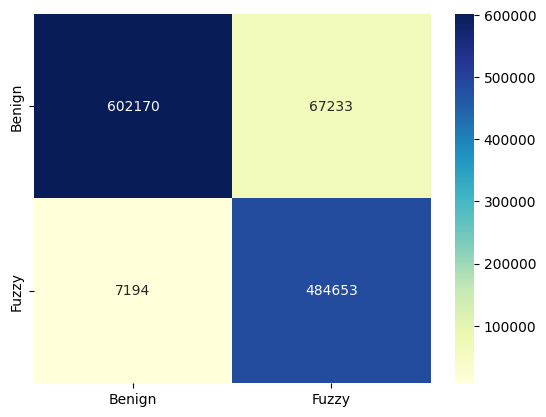

In [ ]:
#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_rtest,y_pred))
print("Classification Report :")
print(classification_report(Y_rtest,y_pred))

cm = confusion_matrix(Y_rtest, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **IF_REAL_0.3**

In [ ]:
# Isolation Forest 모델 생성 및 학습
clf = IsolationForest(n_estimators=100, max_samples=len(encoded_X_train), contamination=0.3,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2

Accuracy Score :
0.8269003229278794
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70      0.82    669403
           2       0.71      1.00      0.83    491847

    accuracy                           0.83   1161250
   macro avg       0.85      0.85      0.83   1161250
weighted avg       0.88      0.83      0.83   1161250



<Axes: >

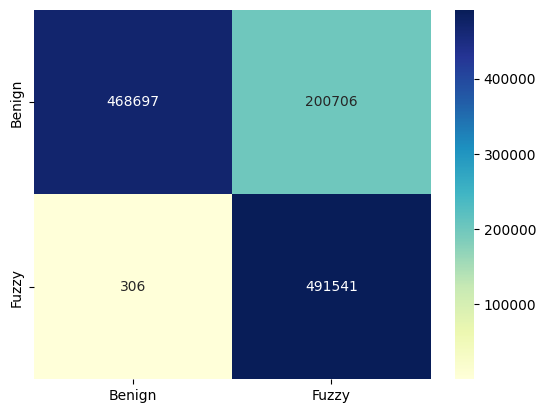

In [ ]:
#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_rtest,y_pred))
print("Classification Report :")
print(classification_report(Y_rtest,y_pred))

cm = confusion_matrix(Y_rtest, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **IF_REAL_auto**

In [ ]:
# Isolation Forest 모델 생성 및 학습
contamination = 'auto'
clf = IsolationForest(n_estimators=100, max_samples=len(encoded_X_train), contamination=contamination,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

In [ ]:
cnt=0
for keys in Y_train:
  if keys==0:
    cnt+=1
print(cnt)

2677610


In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2
print(contamination)

auto


Accuracy Score :
0.9782079655543595
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    669403
           2       0.98      0.97      0.97    491847

    accuracy                           0.98   1161250
   macro avg       0.98      0.98      0.98   1161250
weighted avg       0.98      0.98      0.98   1161250



<Axes: >

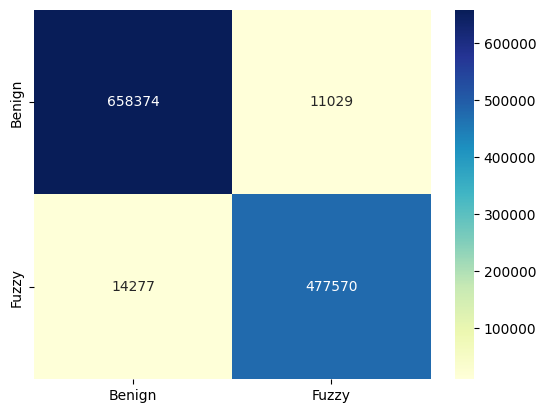

In [ ]:
#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_rtest,y_pred))
print("Classification Report :")
print(classification_report(Y_rtest,y_pred))

cm = confusion_matrix(Y_rtest, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')